In [3]:
import numpy as np
import pandas as pd
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib # save and load model
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score


/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


We already know Trigram + Remove Stopwords + SVM gives the performance. I also noticed that the test set is quite big, i.e. the same size as the traning set + validation set. So I decided to split some data from the test set to the training set and test the performance.

In [1]:
reviews_train = []
for line in open('../data/movie_data/full_train.txt', 'r'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('../data/movie_data/full_test.txt', 'r'):
    
    reviews_test.append(line.strip())
    
target = [1 if i < 12500 else 0 for i in range(25000)]

In [3]:
reviews_all = reviews_train + reviews_test
target_all  = target + target
reviews_X_train, reviews_X_test, reviews_y_train, reviews_y_test = train_test_split(reviews_all, target_all, test_size=0.2, random_state=42)

In [5]:
# Test data from Tieto
path = '../data/movie_review_data'
classes = ['neg', 'pos']
labels    = []
test_data_mine = []
space = ' '
for j in range(len(classes)):
  file_list = os.listdir(path+'/'+classes[j])
  for i in file_list:
    labels.append(j)
    comment = open(path+'/'+classes[j]+'/'+i).read()
    comment = comment.replace('\n',' ')
    test_data_mine.append(comment)
# test_data = np.array(test_data)
len(test_data_mine)

1999

In [4]:
# Rotten Tomato Data, only training set has labels
rotten_tomato_train = pd.read_csv('../data/rottenTomatoes/train.tsv', sep = '\t')
rotten_tomato_test  = pd.read_csv('../data/rottenTomatoes/test.tsv', sep = '\t')
rotten_tomato_train.drop_duplicates(subset = ['SentenceId'], keep='first', inplace = True)
rotten_tomato_test.drop_duplicates(subset = ['SentenceId'], keep='first', inplace = True)
rotten_tomato_train = rotten_tomato_train[~rotten_tomato_train['Sentiment'].isin([2])]
rotten_tomato_train['Label'] = rotten_tomato_train['Sentiment'].apply(lambda x: 1 if x>2 else 0)
rotten_tomato_train_x = list(rotten_tomato_train['Phrase'])
rotten_tomato_train_y = list(rotten_tomato_train['Label'])
rotten_tomato_train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,Label
0,1,1,A series of escapades demonstrating the adage ...,1,0
63,64,2,"This quiet , introspective and entertaining in...",4,1
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,0
116,117,4,A positively thrilling combination of ethnogra...,3,1
156,157,5,Aggressive self-glorification and a manipulati...,1,0
166,167,6,A comedy-drama of nearly epic proportions root...,4,1
198,199,7,"Narratively , Trouble Every Day is a plodding ...",1,0
213,214,8,"The Importance of Being Earnest , so thick wit...",3,1
247,248,9,But it does n't leave you with much .,1,0
259,260,10,You could hate it for the same reason .,1,0


In [7]:
# Preprocessing using regular expressions

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

# Replace the abbreviation with the complete words
def _replacer(text):
    replacement_patterns = [
        (r'won\'t', 'will not'),
        (r'can\'t', 'cannot'),
        (r'i\'m', 'i am'),
        (r'ain\'t', 'is not'),
        (r'(\w+)\'ll', r'\g<1> will'),
        (r'(\w+)n\'t', r'\g<1> not'),
        (r'(\w+)\'ve', r'\g<1> have'),
        (r'(\w+)\'s', r'\g<1> is'),
        (r'(\w+)\'re', r'\g<1> are'),
        (r'(\w+)\'d', r'\g<1> would')]
    patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]
    s = text
    for (pattern, repl) in patterns:
        (s, _) = re.subn(pattern, repl, s)
    return s

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    reviews = [_replacer(line) for line in reviews]
    
    return reviews

In [8]:
reviews_train_clean = preprocess_reviews(reviews_X_train)
reviews_test_clean = preprocess_reviews(reviews_X_test)
rotten_tomato_clean = preprocess_reviews(rotten_tomato_train_x)

In [9]:
# Manually check the effect
preprocess_reviews(['I don\'t like this'])

['i do not like this']

# Baseline 

## CountVectorizer + Logistic Regression

In [39]:
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train_clean)
X_baseline = baseline_vectorizer.transform(reviews_train_clean)
X_test_baseline = baseline_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X_baseline, reviews_y_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, max_iter = 200, n_jobs =8)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    print ('F1 Score: {}'.format(f1_score(y_val, lr.predict(X_val))))

final_model = LogisticRegression(C=0.05, max_iter = 200, n_jobs =8)
final_model.fit(X_baseline, reviews_y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(reviews_y_test, final_model.predict(X_test_baseline)))
print ('F1 Score: {}'.format(f1_score(reviews_y_test, final_model.predict(X_test_baseline))))


Accuracy for C=0.01: 0.8843
F1 Score: 0.884265279583875
Accuracy for C=0.05: 0.8925
F1 Score: 0.8924031628465618
Accuracy for C=0.25: 0.8923
F1 Score: 0.8920300751879698
Accuracy for C=0.5: 0.8893
F1 Score: 0.889000300812193
Accuracy for C=1: 0.8862
F1 Score: 0.8857659104597471
Final Accuracy: 0.895
F1 Score: 0.8961013259449833


Confusion matrix, without normalization
[[4422  523]
 [ 527 4528]]
Normalized confusion matrix
[[0.8942366  0.1057634 ]
 [0.10425321 0.89574679]]


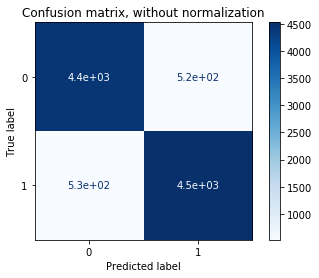

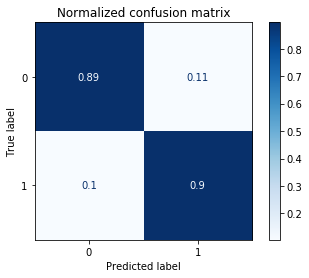

In [40]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final_model, X_test_baseline, reviews_y_test,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Splitting more data from test set to training set does help improve the performance.

ACC: 0.8839419709854928
F1 Score: 0.8846918489065606
Confusion matrix, without normalization
[[877 122]
 [110 890]]
Normalized confusion matrix
[[0.87787788 0.12212212]
 [0.11       0.89      ]]


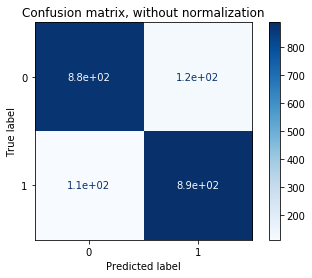

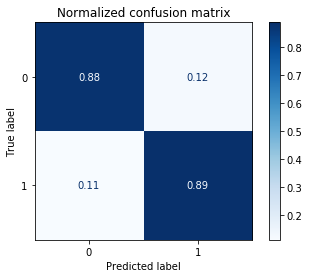

In [41]:
# Test with Tieto Data
test = preprocess_reviews(test_data_mine)
test = baseline_vectorizer.transform(test)
print('ACC: {}'.format(accuracy_score(labels, final_model.predict(test))))
print ('F1 Score: {}'.format(f1_score(labels, final_model.predict(test))))


# Plot non-normalized confusion matrix of tieto data
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final_model, test,labels,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

ACC: 0.7160314227524004
F1 Score: 0.7695939565627951
Confusion matrix, without normalization
[[1662 1610]
 [ 342 3260]]
Normalized confusion matrix
[[0.50794621 0.49205379]
 [0.09494725 0.90505275]]


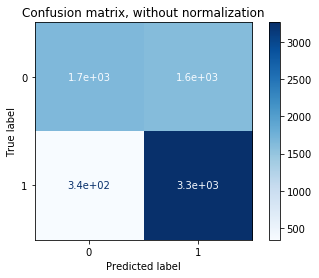

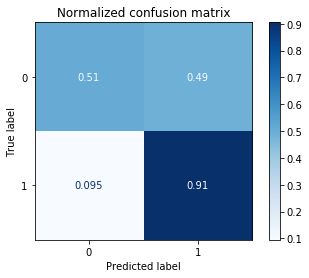

In [42]:
# Plot non-normalized confusion matrix of rotten tomato data
rotten_tomato = baseline_vectorizer.transform(rotten_tomato_clean)
print('ACC: {}'.format(accuracy_score(rotten_tomato_train_y, final_model.predict(rotten_tomato))))
print ('F1 Score: {}'.format(f1_score(rotten_tomato_train_y, final_model.predict(rotten_tomato))))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final_model, rotten_tomato,rotten_tomato_train_y,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Final Model

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, reviews_y_train, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    print ('F1 Score: {}'.format(f1_score(y_val, svm.predict(X_val))))
    
final = LinearSVC(C=0.01)
final.fit(X, reviews_y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(reviews_y_test, final.predict(X_test)))
print ('F1 Score: {}'.format(f1_score(reviews_y_test, final.predict(X_test))))

Accuracy for C=0.001: 0.9011
F1 Score: 0.9016605349507806
Accuracy for C=0.005: 0.9074
F1 Score: 0.9079339828991848
Accuracy for C=0.01: 0.9073
F1 Score: 0.9077520151258831
Accuracy for C=0.05: 0.9066
F1 Score: 0.9069350338780391
Accuracy for C=0.1: 0.9063
F1 Score: 0.9065895723257901
Final Accuracy: 0.9099
F1 Score: 0.9111352204359405


Confusion matrix, without normalization
[[4480  465]
 [ 436 4619]]
Normalized confusion matrix
[[0.90596562 0.09403438]
 [0.08625124 0.91374876]]


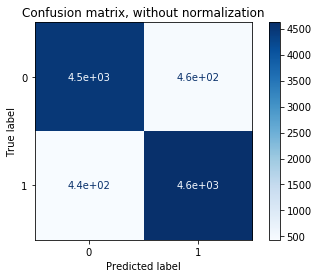

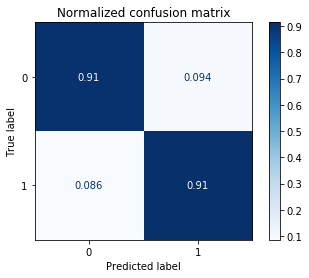

In [17]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final, X_test, reviews_y_test,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Final Accuracy: 0.7109397730578993
F1 Score: 0.7706866705135602
Confusion matrix, without normalization
[[1548 1724]
 [ 263 3339]]
Normalized confusion matrix
[[0.47310513 0.52689487]
 [0.07301499 0.92698501]]


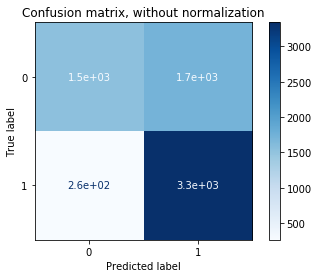

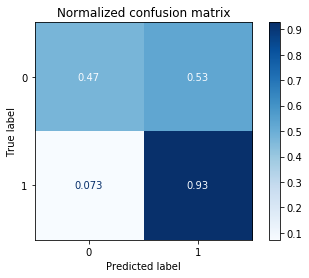

In [18]:
# Plot non-normalized confusion matrix of rotten tomato data

rotten_tomato = ngram_vectorizer.transform(rotten_tomato_clean)
print ("Final Accuracy: %s" 
       % accuracy_score(rotten_tomato_train_y, final.predict(rotten_tomato)))
print ('F1 Score: {}'.format(f1_score(rotten_tomato_train_y, final.predict(rotten_tomato))))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final, rotten_tomato,rotten_tomato_train_y,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

ACC: 0.9069534767383692
F1 Score: 0.9065326633165829
Confusion matrix, without normalization
[[911  88]
 [ 98 902]]
Normalized confusion matrix
[[0.91191191 0.08808809]
 [0.098      0.902     ]]


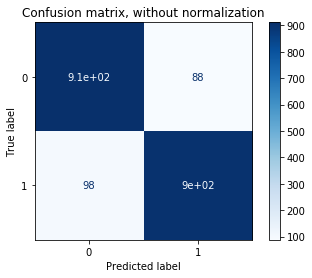

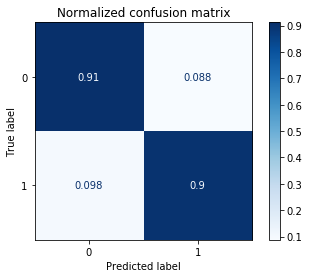

In [19]:
# Test with Tieto Data
test = preprocess_reviews(test_data_mine)
test = ngram_vectorizer.transform(test)
print('ACC: {}'.format(accuracy_score(labels, final.predict(test))))
print ('F1 Score: {}'.format(f1_score(labels, final.predict(test))))

# Plot non-normalized confusion matrix of tieto data
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final, test,labels,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [20]:
# Save model
joblib.dump(final, "final_model_b.m")
joblib.dump(ngram_vectorizer, 'vectorizer_b.m')

['vectorizer_b.m']

In [23]:
# load model and predict
clf = joblib.load("final_model.m")
ngram_vectorizer = joblib.load("vectorizer.m")

test = preprocess_reviews(test_data_mine)
test = ngram_vectorizer.transform(test)
accuracy_score(labels, clf.predict(test))

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.21.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.8994497248624312

In [24]:
# Manual Check
test = "I don't like this movie!"
test = preprocess_reviews([test])
print(test)
test = ngram_vectorizer.transform(test)
print(final.predict(test))

test = "I like this movie!"
test = preprocess_reviews([test])
print(test)
test = ngram_vectorizer.transform(test)
print(final.predict(test))

test = "I do like this movie!"
test = preprocess_reviews([test])
print(test)
test = ngram_vectorizer.transform(test)
print(final.predict(test))

test = "I hate this movie!"
test = preprocess_reviews([test])
print(test)
test = ngram_vectorizer.transform(test)
print(final.predict(test))

['i do not like this movie']


ValueError: X has 5299522 features per sample; expecting 7843645

## Change the number of features for each review

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words, max_features = 500000)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, reviews_y_train, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    print ('F1 Score: {}'.format(f1_score(y_val, svm.predict(X_val))))
    
final = LinearSVC(C=0.01)
final.fit(X, reviews_y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(reviews_y_test, final.predict(X_test)))
print ('F1 Score: {}'.format(f1_score(reviews_y_test, final.predict(X_test))))


Accuracy for C=0.001: 0.9001
F1 Score: 0.8996887237674465
Accuracy for C=0.005: 0.9067
F1 Score: 0.9059949622166246
Accuracy for C=0.01: 0.9046
F1 Score: 0.9037918515530454
Accuracy for C=0.05: 0.9024
F1 Score: 0.9014141414141413
Accuracy for C=0.1: 0.901
F1 Score: 0.8999191265669226
Final Accuracy: 0.9082
F1 Score: 0.9093422871815129


In [36]:
# Checking the size of the features
len(ngram_vectorizer.vocabulary_)

500000

ACC: 0.9064532266133066
F1 Score: 0.9059829059829061
Confusion matrix, without normalization
[[911  88]
 [ 99 901]]
Normalized confusion matrix
[[0.91191191 0.08808809]
 [0.099      0.901     ]]


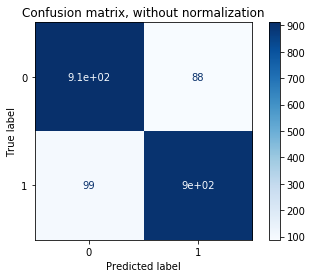

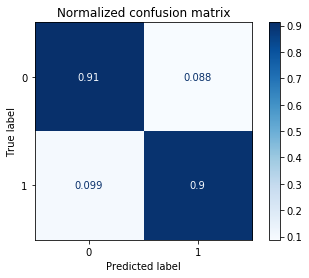

In [37]:
# Test with Tieto Data
test = preprocess_reviews(test_data_mine)
test = ngram_vectorizer.transform(test)
print('ACC: {}'.format(accuracy_score(labels, final.predict(test))))
print ('F1 Score: {}'.format(f1_score(labels, final.predict(test))))

# Plot non-normalized confusion matrix of tieto data
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(final, test,labels,
#                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


It seems that by only considering 500000 features we can get more or less the same performance. Hence we can reduce the size our vocabulary from 5299522 to 500000, which can speed up the loading and computation a lot!

In [38]:
# Save model
joblib.dump(final, "final_model_small.m")
joblib.dump(ngram_vectorizer, 'vectorizer_small.m')

['vectorizer_small.m']

# Top Postitive and Negative Features

In [22]:
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:30]:
    print (best_positive)
    
print("\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:30]:
    print (best_negative)

('excellent', 0.2484980043366227)
('perfect', 0.1974451898028097)
('great', 0.1839051187105768)
('amazing', 0.17830906463025972)
('wonderful', 0.17535317727383767)
('enjoyable', 0.17512887695745086)
('superb', 0.17011746151347246)
('enjoyed', 0.15994526317231672)
('hilarious', 0.1534186385544279)
('fantastic', 0.15233536829987088)
('brilliant', 0.15024007855633664)
('funniest', 0.14676172889898442)
('incredible', 0.13977277596255297)
('today', 0.1385163588738921)
('must see', 0.13588733804928727)
('gem', 0.1340045392415337)
('watch it', 0.13053081675843936)
('loved', 0.1285058411463966)
('surprised', 0.1268795789809017)
('one best', 0.12338702134933997)
('best', 0.12336054259256947)
('refreshing', 0.12053464515983457)
('well worth', 0.11901676639773064)
('fun', 0.11900976691180834)
('subtle', 0.11839993643308376)
('highly', 0.115272952237179)
('loved this', 0.11430130695433555)
('touching', 0.1131292305529065)
('perfectly', 0.11233598474340932)
('outstanding', 0.11099281282668784)



(